In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### 데이터셋 EDA

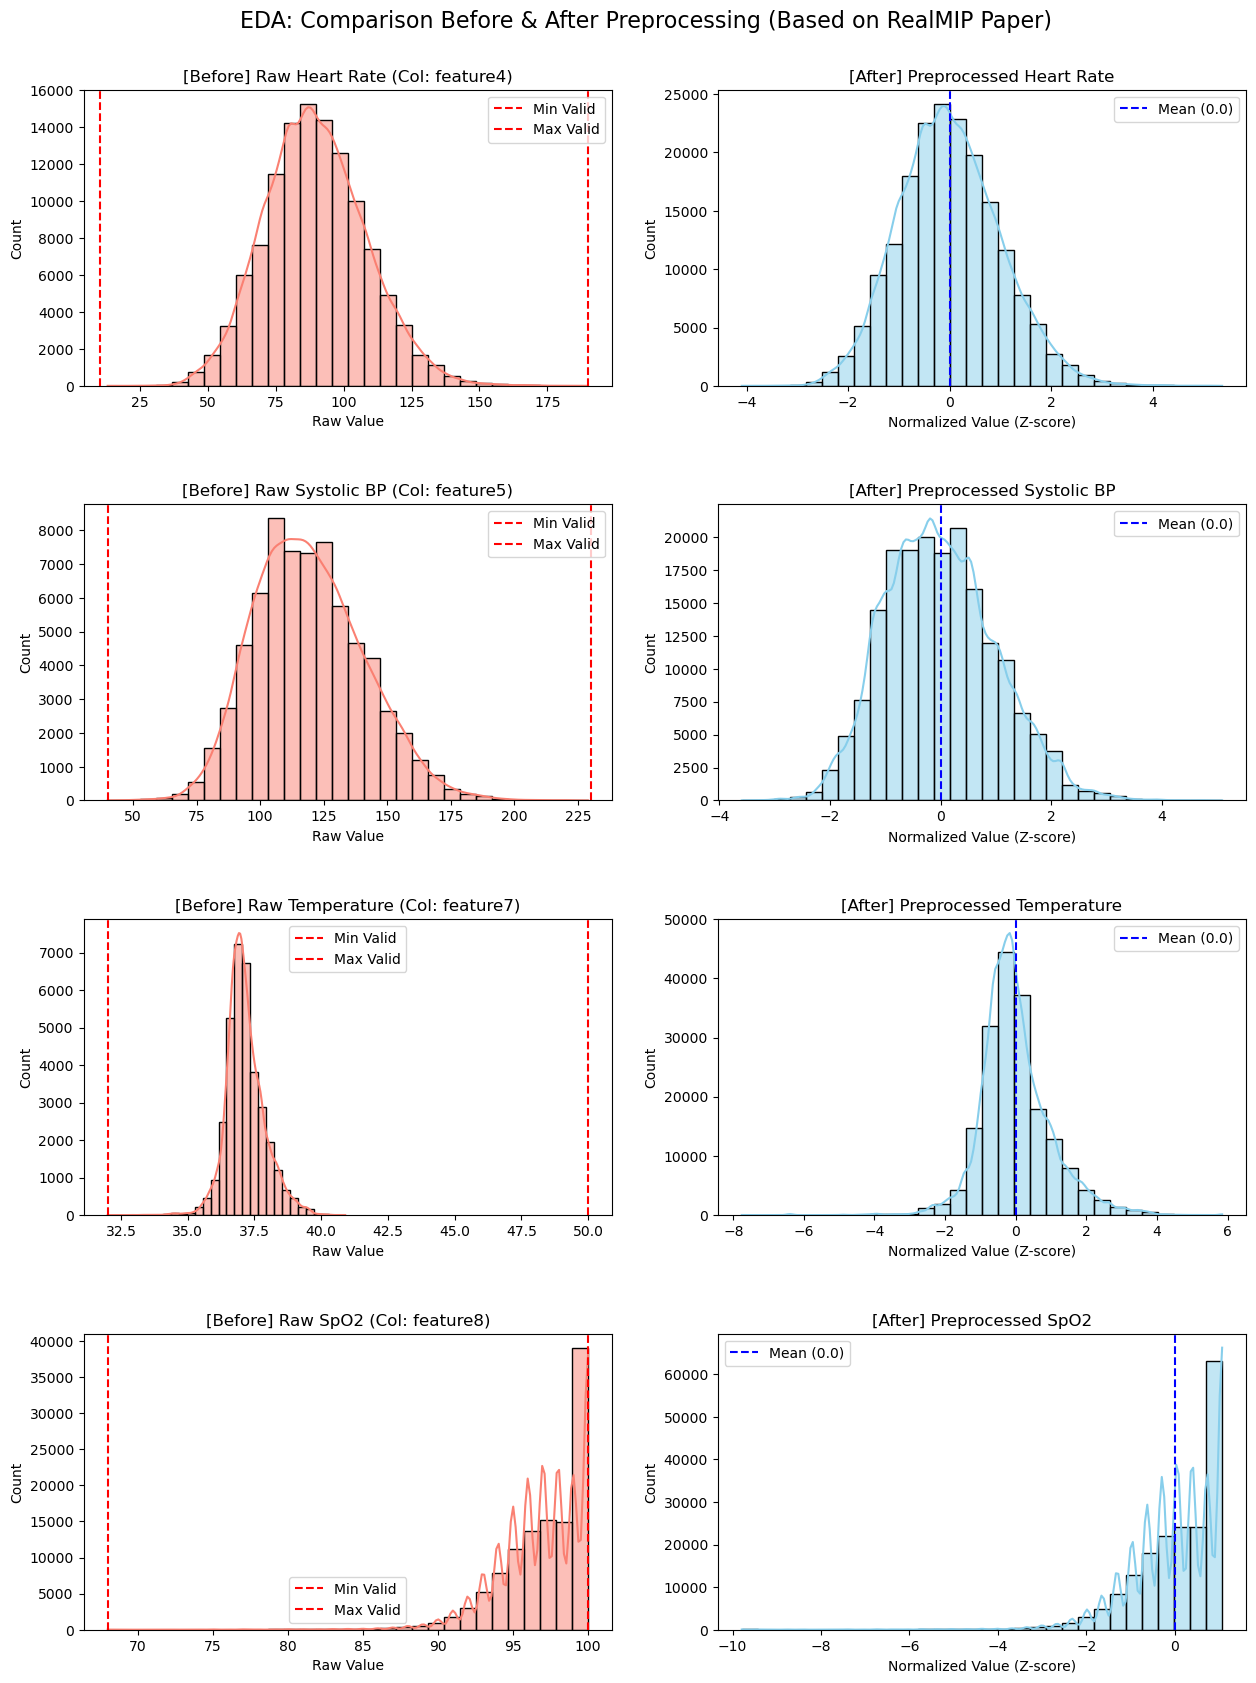

=== Missing Values Analysis ===
Feature         | Before (%)      | After (%)      
--------------------------------------------------
Heart Rate      | 36.73%          | 0.00%
Systolic BP     | 62.90%          | 0.00%
Temperature     | 81.12%          | 0.00%
SpO2            | 38.11%          | 0.00%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
df = pd.read_csv('/home/tjdals/KDT_Project/icu/code/dat/test_merged_age18_60.csv')

# 2. 주요 변수 매핑 및 유효 범위 정의 (논문 Supplementary Table S5 기반)
# 통계적 특성(Mean, Min, Max)을 바탕으로 매칭한 결과입니다.
feature_map = {
    'feature4': {'name': 'Heart Rate', 'range': (10, 190)},
    'feature5': {'name': 'Systolic BP', 'range': (40, 230)},
    'feature7': {'name': 'Temperature', 'range': (32, 50)},
    'feature8': {'name': 'SpO2', 'range': (68, 100)}
}

# 3. 전처리 함수 정의
def preprocess_data(df, mapping):
    df_processed = df.copy()

    # A. 이상치 제거 (Outlier Exclusion)
    for col, info in mapping.items():
        min_val, max_val = info['range']
        # 유효 범위를 벗어나는 값은 결측치(NaN)로 처리
        mask = (df_processed[col] < min_val) | (df_processed[col] > max_val)
        df_processed.loc[mask, col] = np.nan

    # B. 결측치 임시 처리 (EDA를 위해 Forward Fill 적용)
    # 논문의 RealMIP는 복잡한 생성 모델이므로, 여기선 비교를 위해 간단한 보간법 사용
    df_processed = df_processed.ffill().bfill()

    # C. 정규화 (Normalization) - Z-score Standardization
    scaler = StandardScaler()
    cols_to_scale = list(mapping.keys())
    df_processed[cols_to_scale] = scaler.fit_transform(df_processed[cols_to_scale])

    return df_processed

# 4. 전처리 수행
df_after = preprocess_data(df, feature_map)

# 5. 시각화: 전처리 전 vs 후 비교
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4)

for i, (col, info) in enumerate(feature_map.items()):
    name = info['name']
    valid_range = info['range']

    # --- [Before] 전처리 전 ---
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color='salmon', bins=30)
    axes[i, 0].set_title(f'[Before] Raw {name} (Col: {col})')
    axes[i, 0].set_xlabel('Raw Value')

    # 유효 범위 표시 (빨간 점선)
    axes[i, 0].axvline(valid_range[0], color='red', linestyle='--', label='Min Valid')
    axes[i, 0].axvline(valid_range[1], color='red', linestyle='--', label='Max Valid')
    axes[i, 0].legend()

    # --- [After] 전처리 후 ---
    sns.histplot(df_after[col], kde=True, ax=axes[i, 1], color='skyblue', bins=30)
    axes[i, 1].set_title(f'[After] Preprocessed {name}')
    axes[i, 1].set_xlabel('Normalized Value (Z-score)')

    # 정규화 후 평균(0) 표시
    axes[i, 1].axvline(0, color='blue', linestyle='--', label='Mean (0.0)')
    axes[i, 1].legend()

plt.suptitle("EDA: Comparison Before & After Preprocessing (Based on RealMIP Paper)", fontsize=16, y=0.92)
plt.show()

# 6. 결측치 비율 비교 출력
print("=== Missing Values Analysis ===")
print(f"{'Feature':<15} | {'Before (%)':<15} | {'After (%)':<15}")
print("-" * 50)
for col, info in feature_map.items():
    missing_before = df[col].isnull().mean() * 100
    missing_after = df_after[col].isnull().mean() * 100
    print(f"{info['name']:<15} | {missing_before:.2f}%          | {missing_after:.2f}%")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 모델

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import gc
import os
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm
from sklearn.metrics import recall_score, roc_auc_score
from itertools import chain
from torch.utils.data import Sampler

# --- 0. 환경 설정 및 메모리 최적화 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [ ]:
# 통계값 (Standardization용 ; DIffusion Model을 위해 빠른 계싼을 위한 Numpy Index)
mean_val = torch.tensor(
    [6.115921e+01, 0.0, 5.012372e+03, 8.577913e+01, 1.231834e+02, 6.487961e+01,
     1.981481e+01, 3.699407e+01, 9.676768e+01, 5.628323e+00, 3.741237e+00,
     3.576394e+00, 1.126222e+02, 2.730177e+00, 1.060125e+02, 1.392093e+02,
     1.506129e+00, 2.725690e+01, 8.284392e+00, 1.047430e+02, 1.505578e+00,
     1.417590e+02, 1.020023e+01, 3.089938e+01, 2.470126e+01, 4.252328e+01,
     1.160214e+02, 5.111877e+01, 2.031380e+02, 4.016609e+00, 5.781657e+00,
     4.263790e+00, 3.486935e+00, 1.390026e+02, 1.182809e+01, 5.044114e+01,
     4.205614e+02], device=device
)
std_val = torch.tensor(
    [1.596153e+01, 1.0, 7.525188e+03, 1.842967e+01, 2.342812e+01, 1.480334e+01,
     5.885128e+00, 7.552111e-01, 2.966343e+00, 9.935996e-01, 1.682795e+00,
     8.242207e-01, 3.537135e+02, 6.699034e-01, 9.850513e+01, 5.331702e+02,
     3.096187e+00, 2.140450e+01, 7.646539e-01, 6.896862e+00, 1.597400e+00,
     5.823925e+01, 2.166648e+00, 6.353790e+00, 6.220732e+00, 1.169103e+01,
     7.017883e+01, 2.324614e+01, 1.085020e+02, 6.091881e-01, 9.368000e-01,
     1.462472e+00, 7.327223e-01, 5.953719e+00, 6.388267e+00, 3.356331e+02,
     4.840134e+02], device=device
)

In [ ]:
# --- 1. Diffusion 모델 컴포넌트 ---
def get_torch_trans(heads=4, layers=1, channels=64):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=channels, nhead=heads, dim_feedforward=channels*2,
        activation="gelu", batch_first=True, dropout=0.3
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=layers)

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim=64):
        super().__init__()
        self.register_buffer('embedding', self._build_embedding(num_steps, embedding_dim // 2))
        self.projection1 = nn.Linear(embedding_dim, embedding_dim)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim)

    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).float()
        freqs = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)
        table = steps * freqs
        return torch.cat([torch.sin(table), torch.cos(table)], dim=1)

    def forward(self, t):
        x = self.embedding[t]
        return F.silu(self.projection2(F.silu(self.projection1(x))))

class ResidualBlock(nn.Module):
    def __init__(self, side_dim, channels, diffusion_embedding_dim, nheads):
        super().__init__()
        self.diffusion_projection = nn.Linear(diffusion_embedding_dim, channels)
        self.cond_projection = nn.Conv1d(side_dim, 2 * channels, 1)
        self.mid_projection = nn.Conv1d(channels, 2 * channels, 1)
        self.output_projection = nn.Conv1d(channels, 2 * channels, 1)
        self.time_layer = get_torch_trans(heads=nheads, layers=1, channels=channels)
        self.feature_layer = get_torch_trans(heads=nheads, layers=1, channels=channels)

    def forward(self, x, cond_info, diffusion_emb, seq_length):
        B, channel, K, L = x.shape
        x_flat = x.view(B, channel, K * L)
        y = x_flat + self.diffusion_projection(diffusion_emb).unsqueeze(-1)

        # Time attention
        y = y.view(B, channel, K, L).permute(0, 2, 1, 3).reshape(B * K, channel, L).permute(2, 0, 1)
        y = self.time_layer(y).permute(1, 2, 0).view(B, K, channel, L).permute(0, 2, 1, 3).reshape(B, channel, K * L)

        y = self.mid_projection(y) + self.cond_projection(cond_info.view(B, -1, K * L))
        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)
        res, skip = torch.chunk(self.output_projection(y), 2, dim=1)
        return (x_flat + res).view(B, channel, K, L) / math.sqrt(2.0), skip.view(B, channel, K, L)

class diff_CSDI(nn.Module):
    def __init__(self, config, inputdim=2):
        super().__init__()
        self.channels = config["channels"]
        self.diffusion_embedding = DiffusionEmbedding(config["num_steps"], config["diffusion_embedding_dim"])
        self.input_projection = nn.Conv1d(inputdim, self.channels, 1)
        self.output_projection1 = nn.Conv1d(self.channels, self.channels, 1)
        self.output_projection2 = nn.Conv1d(self.channels, 1, 1)
        nn.init.zeros_(self.output_projection2.weight)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(config["side_dim"], self.channels,
                          config["diffusion_embedding_dim"], config["nheads"])
            for _ in range(config["layers"])
        ])

    def forward(self, x, cond_info, t, seq_length):
        B, cin, K, L = x.shape
        x = F.relu(self.input_projection(x.view(B, cin, K * L))).view(B, self.channels, K, L)
        diff_emb = self.diffusion_embedding(t)
        skip_list = []
        for layer in self.residual_layers:
            x, skip = layer(x, cond_info, diff_emb, seq_length)
            skip_list.append(skip)
        x = torch.sum(torch.stack(skip_list), dim=0) / math.sqrt(len(self.residual_layers))
        x = self.output_projection2(F.relu(self.output_projection1(x.view(B, self.channels, K * L))))
        return x.view(B, K, L)


In [ ]:
# --- 2. 메인 모델 ---
class CSDI_base(nn.Module):
    def __init__(self, target_dim, config, device):
        super().__init__()
        self.device, self.target_dim = device, target_dim
        self.embed_layer = nn.Embedding(target_dim, config["model"]["featureemb"])
        config["diffusion"]["side_dim"] = config["model"]["featureemb"] + 1
        self.diffmodel = diff_CSDI(config["diffusion"])
        self.num_steps = config["diffusion"]["num_steps"]
        beta = np.linspace(config["diffusion"]["beta_start"]**0.5,
                           config["diffusion"]["beta_end"]**0.5,
                           self.num_steps) ** 2
        self.register_buffer('alpha_hat', torch.tensor(1 - beta, dtype=torch.float32))
        self.register_buffer('alpha', torch.cumprod(self.alpha_hat, dim=0))

    def get_side_info(self, cond_mask):
        B, K, L = cond_mask.shape
        feat_queries = torch.arange(self.target_dim, device=self.device)
        # 주의: target_dim == K 라는 전제로 설계된 코드
        emb = self.embed_layer(feat_queries).view(1, 1, K, -1).expand(B, L, -1, -1).permute(0, 3, 2, 1)
        return torch.cat([emb, cond_mask.unsqueeze(1)], dim=1)

    def impute(self, observed_data, cond_mask, side_info, n_samples, seq_length):
        B, K, L = observed_data.shape
        imputed_samples = []
        for _ in range(n_samples):
            x = torch.randn_like(observed_data)
            for t in range(self.num_steps - 1, -1, -1):
                d_in = torch.cat(
                    [(cond_mask * observed_data).unsqueeze(1),
                     ((1 - cond_mask) * x).unsqueeze(1)],
                    dim=1
                )
                pred = self.diffmodel(d_in, side_info,
                                      torch.tensor([t], device=self.device),
                                      seq_length)
                c1 = 1 / self.alpha_hat[t]**0.5
                c2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t])**0.5
                x = c1 * (x - c2 * pred)
                if t > 0:
                    sig = (((1 - self.alpha[t-1]) / (1 - self.alpha[t])) *
                           (1 - self.alpha_hat[t]))**0.5
                    x += sig * torch.randn_like(x)
            imputed_samples.append(x)
        return torch.stack(imputed_samples, dim=1)

    def forward(self, batch, is_train=1):
        _, obs_data, obs_mask, gt_mask, _, _, status, _, seq_len = self.process_data(batch)
        cond_mask = (torch.rand_like(obs_mask) < 0.5).float() * obs_mask if is_train else gt_mask
        side_info = self.get_side_info(cond_mask)

        # Diffusion loss
        t = torch.randint(0, self.num_steps, (obs_data.size(0),), device=self.device)
        noise = torch.randn_like(obs_data)
        a = self.alpha[t].view(-1, 1, 1)
        noisy = a**0.5 * obs_data + (1 - a)**0.5 * noise
        d_in = torch.cat(
            [(cond_mask * obs_data).unsqueeze(1),
             ((1 - cond_mask) * noisy).unsqueeze(1)],
            dim=1
        )
        pred = self.diffmodel(d_in, side_info, t, seq_len)
        loss = (((noise - pred) * (obs_mask - cond_mask))**2).sum() / (
            (obs_mask - cond_mask).sum() + 1e-5
        )

        # Imputation
        samples = self.impute(obs_data, cond_mask, side_info,
                              1 if is_train else 3, seq_len)
        return loss, samples.mean(dim=1), (obs_mask - cond_mask), status, obs_data, cond_mask, seq_len

class TSB_eICU(CSDI_base):
    def process_data(self, batch):
        return (
            batch["patient_id"].to(self.device),
            batch["observed_data"].to(self.device).permute(0, 2, 1),
            batch["observed_mask"].to(self.device).permute(0, 2, 1),
            batch["gt_mask"].to(self.device).permute(0, 2, 1),
            None,
            None,
            batch["status"].to(self.device),
            None,
            batch["seq_length"].to(self.device),
        )

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=36, hidden_dim=128, num_layers=1):
        super().__init__()  # <--- 이 줄이 반드시 필요합니다!

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0, # 레이어가 1개일 땐 dropout이 0이어야 에러가 안 납니다.
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 2) # 이진 분류(CrossEntropy)이므로 2 유지

    def forward(self, x, seq_lengths):
        # x shape: [B, K, L] -> [B, L, K]로 변환 (CSDI 출력 규격 때문)
        if x.shape[1] == 36:
            x = x.permute(0, 2, 1)

        # 가변 길이 처리를 위한 Pack
        from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
        packed_input = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, _ = self.lstm(packed_input)

        # 마지막 타임스텝의 hidden state 추출 (Bidirectional 고려)
        # Bidirectional LSTM의 경우 h_n의 마지막 두 층을 사용
        _, (h_n, _) = self.lstm(packed_input)

        # h_n shape: [num_layers * num_directions, batch, hidden_dim]
        # 마지막 층의 forward(h_n[-2])와 backward(h_n[-1])를 합침
        h_cat = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)

        return self.fc(self.dropout(h_cat))

In [ ]:
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size

        # 0(생존)과 1(사망)의 인덱스를 분리
        self.pos_indices = np.where(dataset.labels == 1)[0]
        self.neg_indices = np.where(dataset.labels == 0)[0]

        # 배치 구성을 1:1로 맞추기 위해 절반 크기 계산
        self.n_samples = self.batch_size // 2

        # 전체 데이터셋을 다 돌 수 있을 만큼의 배치 수 계산
        self.num_batches = len(dataset) // batch_size

    def __iter__(self):
        for _ in range(self.num_batches):
            # 사망자(Pos)에서 절반 랜덤 추출 (복원 추출 허용하여 데이터 부족 해결)
            pos_batch = np.random.choice(self.pos_indices, self.n_samples, replace=True)
            # 생존자(Neg)에서 절반 랜덤 추출
            neg_batch = np.random.choice(self.neg_indices, self.n_samples, replace=True)

            # 두 그룹을 합치고 섞음 (중요: 앞쪽이 전부 사망자면 안 됨)
            batch = np.concatenate([pos_batch, neg_batch])
            np.random.shuffle(batch)

            yield batch.astype(int)

    def __len__(self):
        return self.num_batches

In [ ]:
MAX_LEN = 200

class ICU_Dataset(Dataset):
    def __init__(self, filename, target_dim=36):
        # 데이터 로드
        df = pd.read_csv(filename).sort_values(['patientunitstayid', 'observationoffset'])

        self.patients = []
        self.labels = []

        all_cols = df.columns.tolist()
        self.feature_cols = [c for c in all_cols if 'feature' in c]

        # [수정] 통계값(Mean, Std)을 데이터셋 내부에서 계산 (외부 변수 의존 제거)
        # 실제로는 Training Set의 통계값만 사용하는 것이 정석입니다.
        self.m = df[self.feature_cols].mean().values.astype(np.float32)
        self.s = df[self.feature_cols].std().values.astype(np.float32)

        # 환자별 그룹화 및 데이터 저장
        for pid, g in df.groupby('patientunitstayid'):
            g = g.sort_values('observationoffset')
            feats = g[self.feature_cols].values.astype(np.float32)   # [T, K]

            # 결측치 마스크 생성
            obs_mask = (~np.isnan(feats)).astype(np.float32)        # [T, K]
            feats = np.nan_to_num(feats, nan=0.0)

            # 최대 길이 제한
            L = min(len(feats), MAX_LEN)
            feats = feats[:L]
            obs_mask = obs_mask[:L]

            label = int(g['died_in_icu'].iloc[0])
            self.patients.append({
                "patient_id": pid,
                "features": feats,
                "mask": obs_mask,
                "label": label,
            })
            self.labels.append(label)

        self.labels = np.array(self.labels, dtype=np.int64)

        # [참고] Sampler를 쓰면 pos_weight는 굳이 안 써도 되지만,
        # Loss 계산 시 참고용으로 남겨둡니다.
        num_pos = np.sum(self.labels == 1)
        num_neg = len(self.labels) - num_pos
        self.pos_weight = torch.tensor(np.sqrt(num_neg / max(num_pos, 1)), dtype=torch.float32)

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        item = self.patients[idx]
        x = item["features"].astype(np.float32)
        m = item["mask"].astype(np.float32)
        y = item["label"]
        L = len(x)

        # 정규화 (Z-score)
        x = (x - self.m) / (self.s + 1e-6)

        return (
            torch.tensor(item["patient_id"]),
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(m, dtype=torch.float32),
            torch.tensor(y, dtype=torch.long),
            torch.tensor(L, dtype=torch.long),
        )

# collate_fn은 그대로 사용
def collate_fn(batch):
    pid, feats, mask, stat, length = zip(*batch)
    padded_feats = pad_sequence(feats, batch_first=True)
    padded_mask  = pad_sequence(mask, batch_first=True)
    return {
        "patient_id": torch.stack(pid),
        "observed_data": padded_feats,
        "observed_mask": padded_mask,
        "gt_mask": padded_mask.clone(),
        "status": torch.stack(stat),
        "seq_length": torch.stack(length),
    }

In [ ]:
import torch
import gc

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# 학습 시작 전 호출
clear_memory()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

config = {
    "diffusion": {
        "layers": 2, "channels": 64, "nheads": 4,
        "diffusion_embedding_dim": 128,
        "beta_start": 0.0001, "beta_end": 0.5, "num_steps": 10
    },
    "model": {"featureemb": 16},
    "train": {"epochs": 50, "batch_size": 64, "accum": 4, "lr": 5e-5, "wd": 1e-4} # batch_size 4->8 추천 (Sampler 효과 위해)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 로드
print(">>> 데이터셋 로드 중...")
train_dataset = ICU_Dataset('/content/drive/MyDrive/final_dataset/29757_train_merged.csv')
test_dataset  = ICU_Dataset('/content/drive/MyDrive/final_dataset/29757_test_merged.csv')

# [2] DataLoader 설정 (핵심 변경 구간)
# Train: Sampler 적용, shuffle=False (Sampler가 섞어줌)
train_sampler = BalancedBatchSampler(train_dataset, batch_size=config["train"]["batch_size"])
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler, # batch_size 파라미터 대신 이걸 씀
    collate_fn=collate_fn
)

# Test: 기존 방식 유지 (평가는 불균형한 상태 그대로 해야 정확함)
test_loader = DataLoader(
    test_dataset,
    batch_size=config["train"]["batch_size"],
    shuffle=False,
    collate_fn=collate_fn
)

# 모델 초기화
model_Gen = TSB_eICU(36, config, device).to(device)
# Dropout이 적용된 LSTMModel 사용 권장 (이전 대화 코드 참고)
model_Pre = LSTMModel(36).to(device)

optimizer = AdamW(
    chain(model_Gen.parameters(), model_Pre.parameters()),
    lr=config["train"]["lr"],
    weight_decay=config["train"]["wd"]
)
scaler = torch.amp.GradScaler()

history = {'loss': [], 'auc': [], 'precision': [], 'recall': [], 'f1': []}
num_epochs = config["train"]["epochs"]

print(">>> 학습 시작: 상세 지표 및 Confusion Matrix 출력 모드")

for epoch in range(num_epochs):
    # ===== Train =====
    model_Gen.train()
    model_Pre.train()

    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}")
    optimizer.zero_grad(set_to_none=True)

    for i, batch in enumerate(pbar):
        with torch.amp.autocast(device_type='cuda', enabled=(device.type == 'cuda')):
            loss0, imputed, _, status, _, _, seq_len = model_Gen(batch, is_train=1)
            imputed_detached = imputed.detach()
            outputs = model_Pre(imputed_detached, seq_len)
            loss2 = F.cross_entropy(outputs, status.to(device))

            range_loss = (torch.clamp(torch.abs(imputed) - 5, min=0)**2).mean()
            total_loss = (loss0 + 2.0 * loss2 + 0.01 * range_loss) / config["train"]["accum"]

        if not torch.isnan(total_loss):
            scaler.scale(total_loss).backward()
            if (i + 1) % config["train"]["accum"] == 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(chain(model_Gen.parameters(), model_Pre.parameters()), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            epoch_loss += total_loss.item() * config["train"]["accum"]
            pbar.set_postfix(loss=total_loss.item() * config["train"]["accum"])

    avg_train_loss = epoch_loss / len(train_loader)

    # ===== Validation (상세 지표 산출) =====
    model_Gen.eval()
    model_Pre.eval()
    val_probs, val_labels = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"[Valid] Epoch {epoch+1}/{num_epochs}"):
            _, imputed, _, status, _, _, seq_len = model_Gen(batch, is_train=0)
            out = model_Pre(imputed, seq_len)
            val_probs.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            val_labels.append(status.cpu().numpy())

    y_true_val = np.concatenate(val_labels)
    y_scores_val = np.concatenate(val_probs)

    # 0.5 임계값 기준으로 이진 분류 결과 생성
    y_pred_val = (y_scores_val > 0.5).astype(int)

    # 지표 계산
    try:
        epoch_auc = roc_auc_score(y_true_val, y_scores_val)
    except ValueError:
        epoch_auc = 0.5

    epoch_precision = precision_score(y_true_val, y_pred_val, zero_division=0)
    epoch_recall = recall_score(y_true_val, y_pred_val, zero_division=0)
    epoch_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)
    cm = confusion_matrix(y_true_val, y_pred_val)

    # 히스토리 저장
    history['loss'].append(avg_train_loss)
    history['auc'].append(epoch_auc)
    history['precision'].append(epoch_precision)
    history['recall'].append(epoch_recall)
    history['f1'].append(epoch_f1)

    # 결과 출력
    print(f"\n--- Epoch {epoch+1}/{num_epochs} Result ---")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"AUC: {epoch_auc:.4f} | Precision: {epoch_precision:.4f} | Recall: {epoch_recall:.4f} | F1: {epoch_f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"  (TN: {cm[0][0]}, FP: {cm[0][1]})")
    print(f"  (FN: {cm[1][0]}, TP: {cm[1][1]})")
    print("-" * 40)



>>> 데이터셋 로드 중...
>>> 학습 시작: 상세 지표 및 Confusion Matrix 출력 모드


[Valid] Epoch 1/50: 100%|██████████| 115/115 [13:38<00:00,  7.11s/it]



--- Epoch 1/50 Result ---
Train Loss: 2.3856
AUC: 0.5209 | Precision: 0.0703 | Recall: 0.4622 | F1: 0.1221
Confusion Matrix:
[[3970 2909]
 [ 256  220]]
  (TN: 3970, FP: 2909)
  (FN: 256, TP: 220)
----------------------------------------


[Valid] Epoch 2/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 2/50 Result ---
Train Loss: 2.2214
AUC: 0.4914 | Precision: 0.0631 | Recall: 0.3193 | F1: 0.1054
Confusion Matrix:
[[4624 2255]
 [ 324  152]]
  (TN: 4624, FP: 2255)
  (FN: 324, TP: 152)
----------------------------------------


[Valid] Epoch 3/50: 100%|██████████| 115/115 [13:37<00:00,  7.11s/it]



--- Epoch 3/50 Result ---
Train Loss: 2.0535
AUC: 0.5550 | Precision: 0.0740 | Recall: 0.6134 | F1: 0.1320
Confusion Matrix:
[[3223 3656]
 [ 184  292]]
  (TN: 3223, FP: 3656)
  (FN: 184, TP: 292)
----------------------------------------


[Valid] Epoch 4/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 4/50 Result ---
Train Loss: 2.0024
AUC: 0.6092 | Precision: 0.0953 | Recall: 0.5210 | F1: 0.1611
Confusion Matrix:
[[4524 2355]
 [ 228  248]]
  (TN: 4524, FP: 2355)
  (FN: 228, TP: 248)
----------------------------------------


[Valid] Epoch 5/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 5/50 Result ---
Train Loss: 1.9763
AUC: 0.6409 | Precision: 0.1190 | Recall: 0.5021 | F1: 0.1924
Confusion Matrix:
[[5110 1769]
 [ 237  239]]
  (TN: 5110, FP: 1769)
  (FN: 237, TP: 239)
----------------------------------------


[Valid] Epoch 6/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 6/50 Result ---
Train Loss: 1.9449
AUC: 0.7096 | Precision: 0.1396 | Recall: 0.5840 | F1: 0.2253
Confusion Matrix:
[[5165 1714]
 [ 198  278]]
  (TN: 5165, FP: 1714)
  (FN: 198, TP: 278)
----------------------------------------


[Valid] Epoch 7/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 7/50 Result ---
Train Loss: 1.9102
AUC: 0.6922 | Precision: 0.1182 | Recall: 0.4874 | F1: 0.1903
Confusion Matrix:
[[5149 1730]
 [ 244  232]]
  (TN: 5149, FP: 1730)
  (FN: 244, TP: 232)
----------------------------------------


[Valid] Epoch 8/50: 100%|██████████| 115/115 [13:38<00:00,  7.11s/it]



--- Epoch 8/50 Result ---
Train Loss: 1.7343
AUC: 0.8581 | Precision: 0.2567 | Recall: 0.5252 | F1: 0.3448
Confusion Matrix:
[[6155  724]
 [ 226  250]]
  (TN: 6155, FP: 724)
  (FN: 226, TP: 250)
----------------------------------------


[Valid] Epoch 9/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 9/50 Result ---
Train Loss: 1.5354
AUC: 0.8851 | Precision: 0.3168 | Recall: 0.5630 | F1: 0.4054
Confusion Matrix:
[[6301  578]
 [ 208  268]]
  (TN: 6301, FP: 578)
  (FN: 208, TP: 268)
----------------------------------------


[Valid] Epoch 10/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 10/50 Result ---
Train Loss: 1.3993
AUC: 0.9058 | Precision: 0.2866 | Recall: 0.7122 | F1: 0.4087
Confusion Matrix:
[[6035  844]
 [ 137  339]]
  (TN: 6035, FP: 844)
  (FN: 137, TP: 339)
----------------------------------------


[Valid] Epoch 11/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 11/50 Result ---
Train Loss: 1.3236
AUC: 0.9211 | Precision: 0.2383 | Recall: 0.8424 | F1: 0.3715
Confusion Matrix:
[[5597 1282]
 [  75  401]]
  (TN: 5597, FP: 1282)
  (FN: 75, TP: 401)
----------------------------------------


[Valid] Epoch 12/50: 100%|██████████| 115/115 [13:38<00:00,  7.12s/it]



--- Epoch 12/50 Result ---
Train Loss: 1.2637
AUC: 0.9236 | Precision: 0.2356 | Recall: 0.8571 | F1: 0.3696
Confusion Matrix:
[[5555 1324]
 [  68  408]]
  (TN: 5555, FP: 1324)
  (FN: 68, TP: 408)
----------------------------------------


[Valid] Epoch 13/50: 100%|██████████| 115/115 [13:39<00:00,  7.12s/it]



--- Epoch 13/50 Result ---
Train Loss: 1.2396
AUC: 0.9239 | Precision: 0.2202 | Recall: 0.8613 | F1: 0.3507
Confusion Matrix:
[[5427 1452]
 [  66  410]]
  (TN: 5427, FP: 1452)
  (FN: 66, TP: 410)
----------------------------------------


[Valid] Epoch 14/50: 100%|██████████| 115/115 [13:39<00:00,  7.12s/it]



--- Epoch 14/50 Result ---
Train Loss: 1.2254
AUC: 0.9240 | Precision: 0.2164 | Recall: 0.8739 | F1: 0.3470
Confusion Matrix:
[[5373 1506]
 [  60  416]]
  (TN: 5373, FP: 1506)
  (FN: 60, TP: 416)
----------------------------------------


[Valid] Epoch 15/50: 100%|██████████| 115/115 [13:39<00:00,  7.12s/it]



--- Epoch 15/50 Result ---
Train Loss: 1.2275
AUC: 0.9312 | Precision: 0.2328 | Recall: 0.8761 | F1: 0.3679
Confusion Matrix:
[[5505 1374]
 [  59  417]]
  (TN: 5505, FP: 1374)
  (FN: 59, TP: 417)
----------------------------------------


[Valid] Epoch 16/50: 100%|██████████| 115/115 [13:39<00:00,  7.12s/it]



--- Epoch 16/50 Result ---
Train Loss: 1.1951
AUC: 0.9265 | Precision: 0.2033 | Recall: 0.9097 | F1: 0.3323
Confusion Matrix:
[[5182 1697]
 [  43  433]]
  (TN: 5182, FP: 1697)
  (FN: 43, TP: 433)
----------------------------------------


[Valid] Epoch 17/50: 100%|██████████| 115/115 [13:39<00:00,  7.12s/it]



--- Epoch 17/50 Result ---
Train Loss: 1.2000
AUC: 0.9346 | Precision: 0.2023 | Recall: 0.9349 | F1: 0.3326
Confusion Matrix:
[[5124 1755]
 [  31  445]]
  (TN: 5124, FP: 1755)
  (FN: 31, TP: 445)
----------------------------------------


[Valid] Epoch 18/50: 100%|██████████| 115/115 [13:43<00:00,  7.16s/it]



--- Epoch 18/50 Result ---
Train Loss: 1.1830
AUC: 0.9274 | Precision: 0.2039 | Recall: 0.8971 | F1: 0.3323
Confusion Matrix:
[[5212 1667]
 [  49  427]]
  (TN: 5212, FP: 1667)
  (FN: 49, TP: 427)
----------------------------------------


[Valid] Epoch 19/50: 100%|██████████| 115/115 [13:41<00:00,  7.15s/it]



--- Epoch 19/50 Result ---
Train Loss: 1.1804
AUC: 0.9319 | Precision: 0.2340 | Recall: 0.8782 | F1: 0.3696
Confusion Matrix:
[[5511 1368]
 [  58  418]]
  (TN: 5511, FP: 1368)
  (FN: 58, TP: 418)
----------------------------------------


[Valid] Epoch 20/50:   7%|▋         | 8/115 [00:57<12:42,  7.13s/it]

In [ ]:
import torch
import joblib
import os

# 저장할 디렉토리 생성
save_dir = "./saved_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. Diffusion 생성 모델 저장 (model_Gen)
torch.save(model_Gen.state_dict(), f"{save_dir}/RealMIP_Gen.pth")

# 2. LSTM 예측 모델 저장 (model_Pre)
torch.save(model_Pre.state_dict(), f"{save_dir}/RealMIP_Pre.pth")

# 3. 전처리 스케일러 저장 (매우 중요!)
# 학습 때 사용한 mean, std 정보가 있어야 새로운 데이터도 똑같이 변환 가능합니다.
joblib.dump(scaler, f"{save_dir}/data_scaler.pkl")

print(f"✅ 모델 및 스케일러가 {save_dir}에 성공적으로 저장되었습니다.")

✅ 모델 및 스케일러가 ./saved_model에 성공적으로 저장되었습니다.


## 시각화를 위한 코드

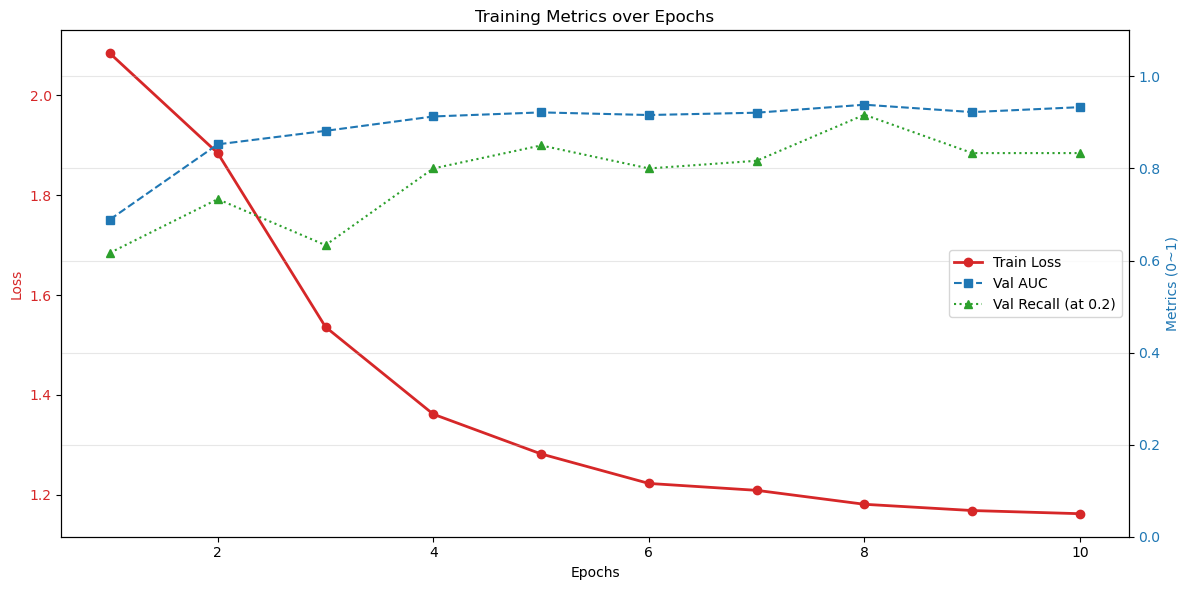

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 1. Loss 그래프 (좌측 축 - 빨간색)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, history['loss'], color='tab:red', marker='o', label='Train Loss', lw=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 2. AUC & Recall 그래프 (우측 축 - 파란색/초록색)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics (0~1)', color='tab:blue')
    ax2.plot(epochs, history['auc'], color='tab:blue', marker='s', label='Val AUC', linestyle='--')
    ax2.plot(epochs, history['recall'], color='tab:green', marker='^', label='Val Recall (at 0.2)', linestyle=':')
    ax2.set_ylim(0, 1.1)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Training Metrics over Epochs')
    fig.tight_layout()

    # 범례 합치기
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')

    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(history)

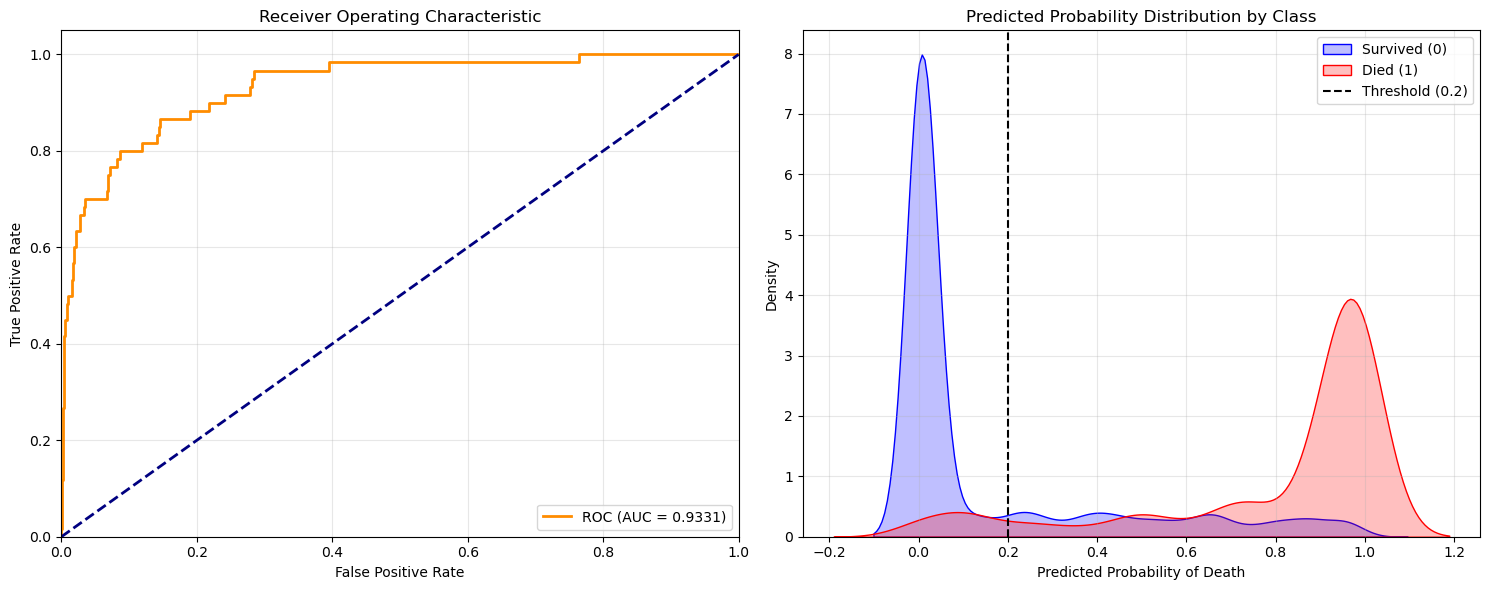

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

def plot_result_analysis(y_true, y_scores):
    plt.figure(figsize=(15, 6))

    # ① ROC 곡선
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_val = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_val:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # ② 예측 확률 밀도 분포 (Class 0 vs 1)
    plt.subplot(1, 2, 2)
    sns.kdeplot(y_scores[y_true == 0], fill=True, color="blue", label="Survived (0)", bw_adjust=0.5)
    sns.kdeplot(y_scores[y_true == 1], fill=True, color="red", label="Died (1)", bw_adjust=0.5)

    plt.axvline(0.2, color='black', linestyle='--', label='Threshold (0.2)')
    plt.title('Predicted Probability Distribution by Class')
    plt.xlabel('Predicted Probability of Death')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# 최종 테스트에서 얻은 변수 사용
plot_result_analysis(y_true_val, y_scores_val)

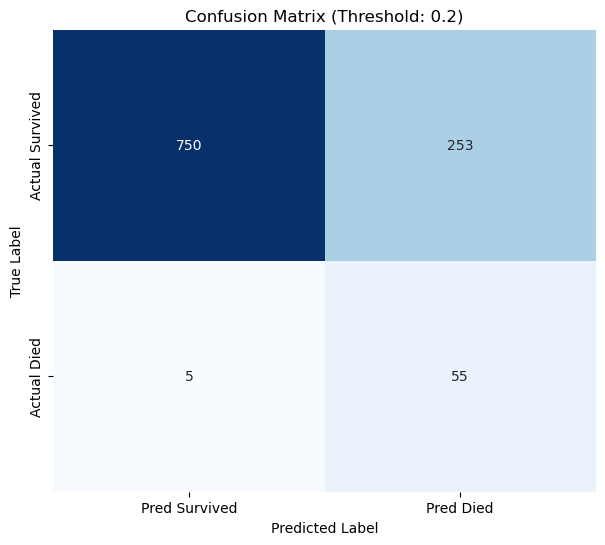

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_final_matrix(y_true, y_scores, threshold=0.2):
    y_pred = (y_scores > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Survived', 'Pred Died'],
                yticklabels=['Actual Survived', 'Actual Died'])
    plt.title(f'Confusion Matrix (Threshold: {threshold})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_final_matrix(y_true_val, y_scores_val)

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score

# 0.01부터 0.5까지 임계값을 변경하며 지표 확인
thresholds = np.arange(0.05, 0.51, 0.05)
print(f"{'Threshold':<12} | {'Recall':<10} | {'Precision':<10} | {'F1-Score':<10}")
print("-" * 50)

for t in thresholds:
    y_pred = (y_scores_val > t).astype(int)
    rec = recall_score(y_true_val, y_pred)
    prec = precision_score(y_true_val, y_pred, zero_division=0)
    f1 = f1_score(y_true_val, y_pred, zero_division=0)
    print(f"{t:<12.2f} | {rec:<10.4f} | {prec:<10.4f} | {f1:<10.4f}")

Threshold    | Recall     | Precision  | F1-Score  
--------------------------------------------------
0.05         | 0.9667     | 0.1593     | 0.2736    
0.10         | 0.9500     | 0.1667     | 0.2836    
0.15         | 0.9167     | 0.1724     | 0.2902    
0.20         | 0.9167     | 0.1786     | 0.2989    
0.25         | 0.9000     | 0.1901     | 0.3140    
0.30         | 0.8833     | 0.2031     | 0.3302    
0.35         | 0.8833     | 0.2087     | 0.3376    
0.40         | 0.8667     | 0.2261     | 0.3586    
0.45         | 0.8667     | 0.2488     | 0.3866    
0.50         | 0.8333     | 0.2604     | 0.3968    


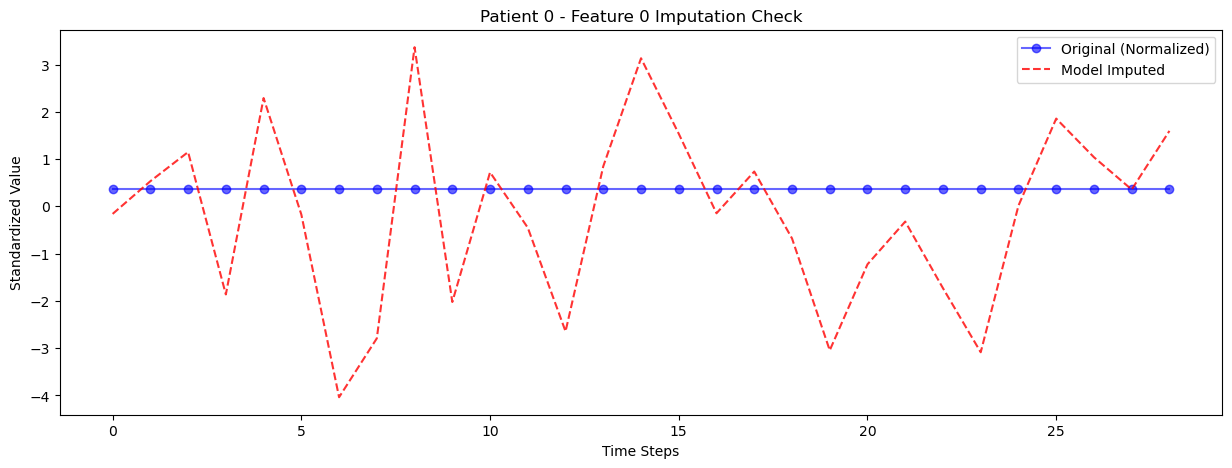

In [ ]:
# 테스트 세트에서 샘플 하나 추출
model_Gen.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    # is_train=0으로 설정하여 gt_mask 기반 보정 수행
    loss, imputed, target_mask, status, obs_data, cond_mask, seq_len = model_Gen(batch, is_train=0)

# 첫 번째 환자의 첫 번째 피처(feature) 시각화
plt.figure(figsize=(15, 5))
patient_idx = 0
feature_idx = 0 # 시각화할 피처 번호 (0~36)

# 원본 관측 데이터 (마스킹 된 부분은 0 혹은 NaN 상태)
plt.plot(obs_data[patient_idx, feature_idx, :seq_len[patient_idx]].cpu(),
         label='Original (Normalized)', color='blue', alpha=0.6, marker='o')

# 모델이 채워 넣은 데이터
plt.plot(imputed[patient_idx, feature_idx, :seq_len[patient_idx]].cpu(),
         label='Model Imputed', color='red', linestyle='--', alpha=0.8)

plt.title(f"Patient {patient_idx} - Feature {feature_idx} Imputation Check")
plt.xlabel("Time Steps")
plt.ylabel("Standardized Value")
plt.legend()
plt.show()

In [ ]:
# 가중치 파일 저장
torch.save(model_Gen.state_dict(), 'model_gen_best.pth')
torch.save(model_Pre.state_dict(), 'model_pre_best.pth')

print("모델 저장 완료: model_gen_best.pth, model_pre_best.pth")

# 나중에 불러오는 코드 (필요할 때 사용):
# model_Gen.load_state_dict(torch.load('model_gen_best.pth'))
# model_Pre.load_state_dict(torch.load('model_pre_best.pth'))

모델 저장 완료: model_gen_best.pth, model_pre_best.pth


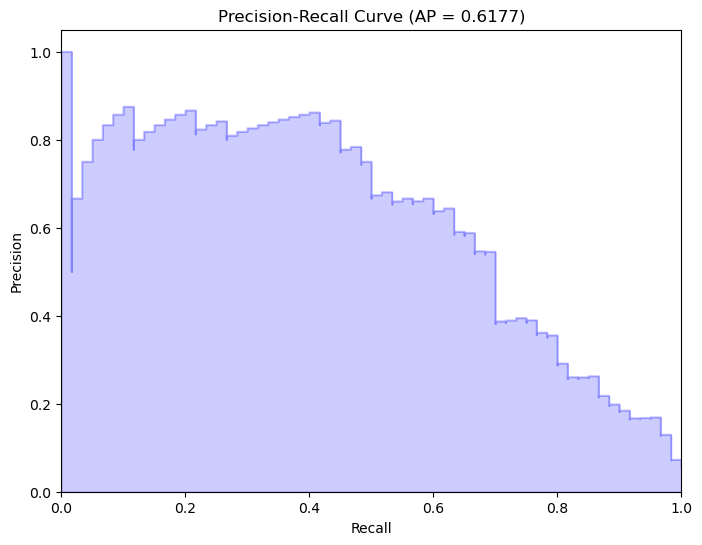

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true_val, y_scores_val)
ap = average_precision_score(y_true_val, y_scores_val)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

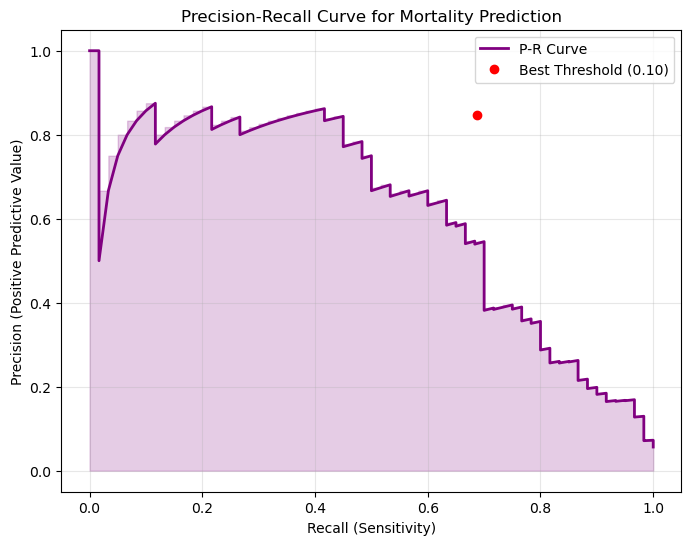

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# PR 곡선 그리기
precisions, recalls, thresholds_pr = precision_recall_curve(y_true_val, y_scores_val)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='purple', lw=2, label='P-R Curve')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='purple')

# 우리가 찾은 최적 점 표시 (Threshold 0.10 지점)
# 주의: thresholds_pr은 precisions/recalls보다 길이가 1 짧습니다.
plt.plot(0.6875, 0.8462, 'ro', label='Best Threshold (0.10)')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve for Mortality Prediction')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()

=== Patient ID: 30003746 시각화 결과 ===


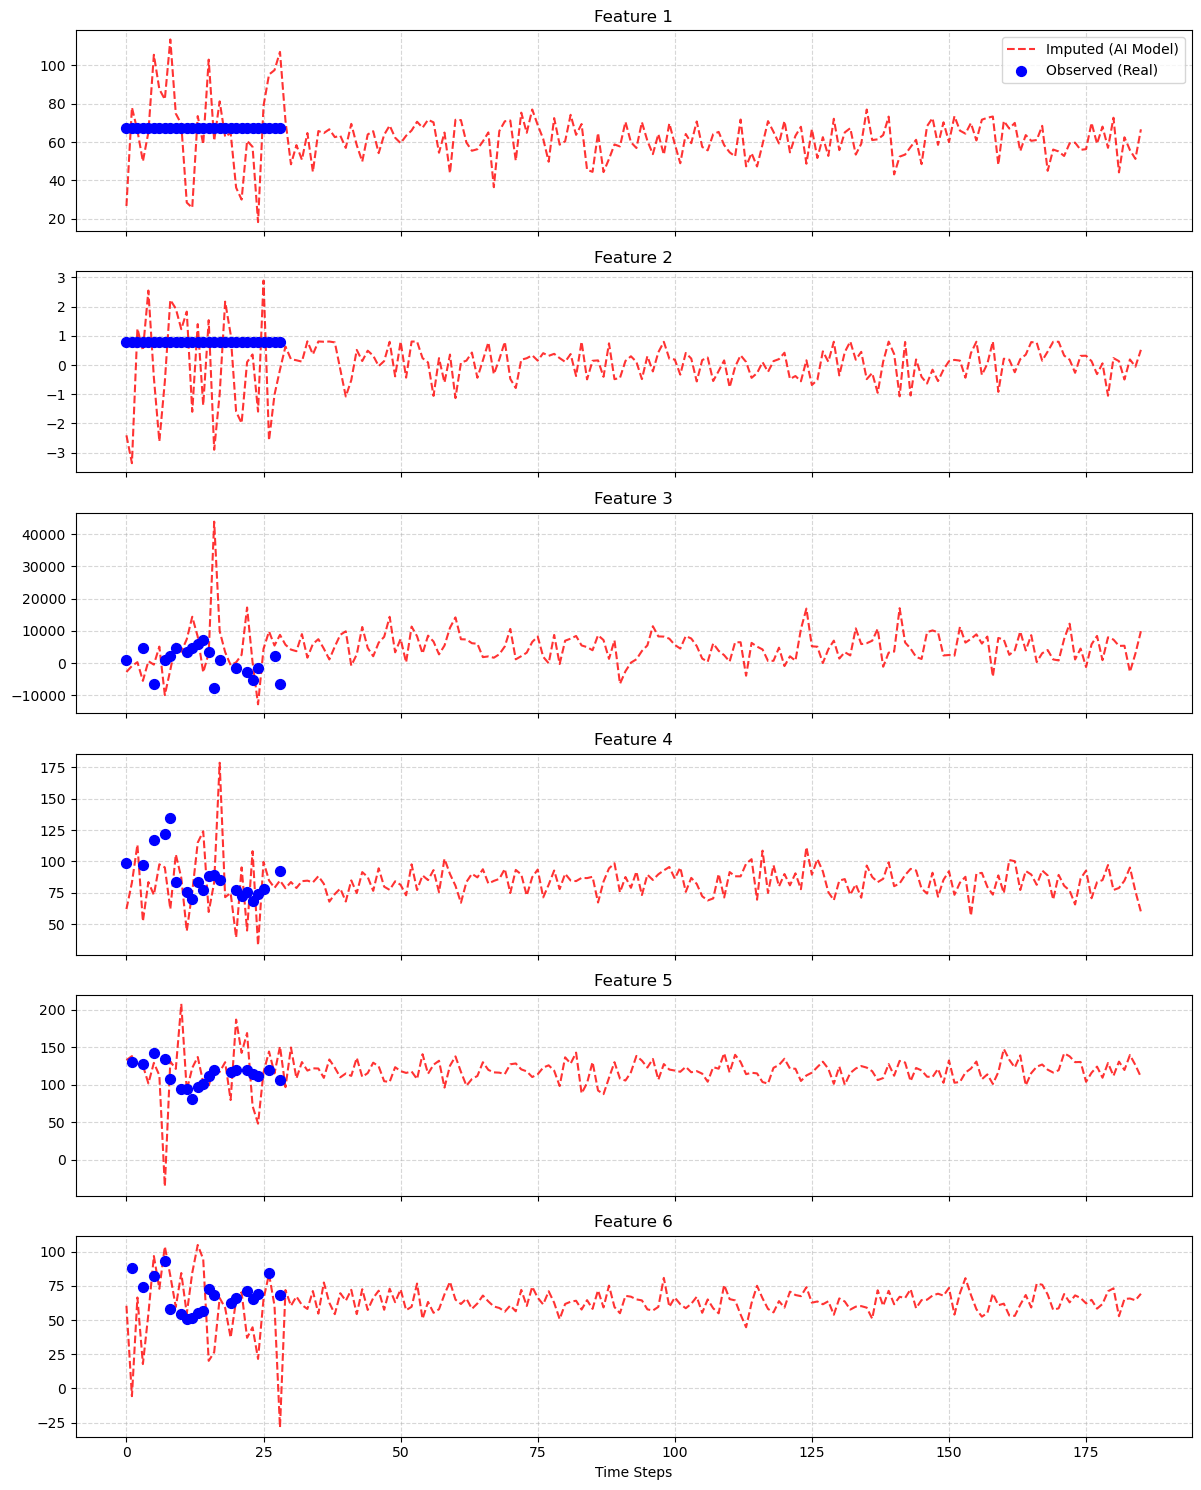

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. 시각화 함수 정의 ---
def visualize_imputation(model, loader, device, mean_val, std_val, patient_idx=0):
    model.eval()

    # 테스트 로더에서 배치를 하나 가져옵니다
    batch = next(iter(loader))

    # 모델 예측 (Imputation)
    with torch.no_grad():
        # is_train=0으로 설정하여 전체 결측치 복원 모드로 실행
        _, imputed, _, _, _, _, _ = model(batch, is_train=0)

    # 데이터 꺼내기 (GPU -> CPU)
    # 모델 출력 shape: (Batch, Channel, Length) -> 시각화를 위해 (Batch, Length, Channel)로 변경
    imputed_data = imputed.permute(0, 2, 1).cpu().numpy()

    # 원본 데이터도 가져오기
    # batch["observed_data"] shape: (Batch, Length, Channel)
    observed_data = batch["observed_data"].cpu().numpy()
    observed_mask = batch["observed_mask"].cpu().numpy()
    patient_ids = batch["patient_id"].numpy()

    # --- 정규화 해제 (Un-normalization) ---
    # 원래 수치로 되돌려야 그래프 해석이 가능합니다.
    # mean_val, std_val은 Tensor이므로 CPU numpy로 변환
    m = mean_val.cpu().numpy()[:imputed_data.shape[2]]
    s = std_val.cpu().numpy()[:imputed_data.shape[2]]

    imputed_real = imputed_data * (s + 1e-6) + m
    observed_real = observed_data * (s + 1e-6) + m

    # --- 그래프 그리기 ---
    # 상위 6개 Feature만 그립니다
    num_features = 6
    fig, axes = plt.subplots(num_features, 1, figsize=(12, 15), sharex=True)

    pid = patient_ids[patient_idx]
    print(f"=== Patient ID: {pid} 시각화 결과 ===")

    for i in range(num_features):
        ax = axes[i]

        # 1. 모델이 복원한 전체 흐름 (빨간 점선)
        ax.plot(imputed_real[patient_idx, :, i], color='red', linestyle='--', alpha=0.8, label='Imputed (AI Model)')

        # 2. 실제 관측된 데이터 (파란 점)
        # 마스크가 1인(실제 데이터가 있는) 지점만 찍습니다
        mask = observed_mask[patient_idx, :, i]
        timesteps = np.arange(len(mask))
        observed_idx = timesteps[mask == 1]
        observed_val = observed_real[patient_idx, observed_idx, i]

        if len(observed_idx) > 0:
            ax.scatter(observed_idx, observed_val, color='blue', s=50, zorder=5, label='Observed (Real)')

        ax.set_title(f"Feature {i+1}")
        ax.grid(True, linestyle='--', alpha=0.5)

        if i == 0:
            ax.legend(loc='upper right')

    plt.xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

# --- 2. 실행 ---
# 위에서 정의한 변수들(model_Gen, test_loader 등)을 그대로 사용합니다.
visualize_imputation(model_Gen, test_loader, device, mean_val, std_val, patient_idx=0)


[Case: 생존 환자 시각화]
=== 🏥 Clinical Analysis | ID: 37438063 | Status: Survived ===


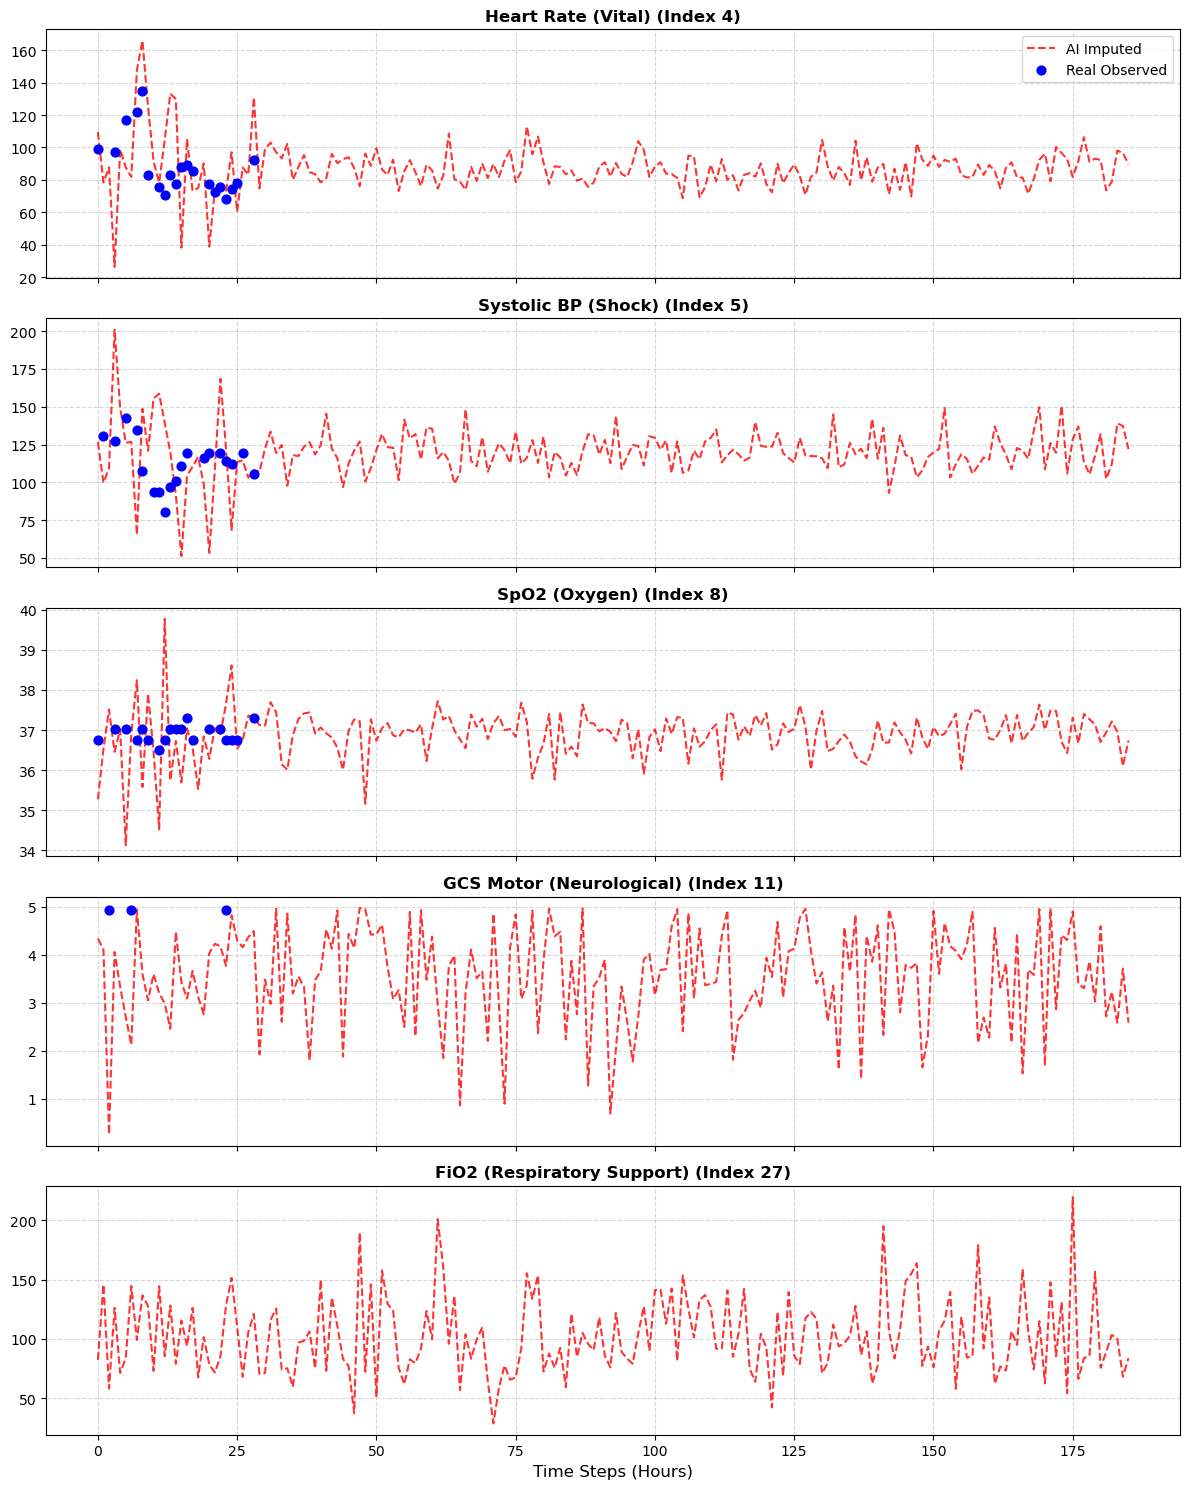

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def visualize_clinical_features(status_type, dataset, model, device, mean_val, std_val):
    """
    status_type: 0 (생존자), 1 (사망자) 중 선택
    """
    # 1. 해당 상태(status)를 가진 환자들의 인덱스 필터링
    target_indices = [i for i, p in enumerate(dataset.patients) if p['label'] == status_type]

    if not target_indices:
        print(f"❌ 데이터셋에 Status {status_type}인 환자가 없습니다.")
        return

    # 2. 필터링된 환자 중 한 명을 랜덤하게 선택
    chosen_idx = random.choice(target_indices)
    data = dataset[chosen_idx]
    target_id = data[0].item() # patient_id

    # 2. 모델 예측
    model.eval()
    with torch.no_grad():
        _, imputed, _, _, _, _, _ = model(batch, is_train=0)

    # 3. 데이터 변환 및 정규화 해제
    imputed_data = imputed.permute(0, 2, 1).cpu().numpy()
    observed_data = batch["observed_data"].cpu().numpy()
    observed_mask = batch["observed_mask"].cpu().numpy()

    m = mean_val.cpu().numpy()[:imputed_data.shape[2]]
    s = std_val.cpu().numpy()[:imputed_data.shape[2]]

    imputed_real = imputed_data * (s + 1e-6) + m
    observed_real = observed_data * (s + 1e-6) + m

    # 4. 논문 근거 중요 변수 매핑 (인덱스는 0부터 시작)
    # [0:나이, 3:심박수, 4:수축기혈압, 7:산소포화도, 10:GCS(의식), 26:FiO2(산소농도)]
    selected_features = [
        (3, "Heart Rate (Vital)"),
        (4, "Systolic BP (Shock)"),
        (7, "SpO2 (Oxygen)"),
        (10, "GCS Motor (Neurological)"),
        (26, "FiO2 (Respiratory Support)")
    ]

    # 5. 그래프 그리기
    num_plots = len(selected_features)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), sharex=True)

    status_str = "Died" if data[3].item() == 1 else "Survived"
    print(f"=== 🏥 Clinical Analysis | ID: {target_id} | Status: {status_str} ===")

    for i, (idx, name) in enumerate(selected_features):
        ax = axes[i]

        # 모델 예측 (AI가 그린 궤적)
        ax.plot(imputed_real[0, :, idx], color='red', linestyle='--', alpha=0.8, label='AI Imputed')

        # 실제 데이터 (관측된 지점)
        mask = observed_mask[0, :, idx]
        observed_idx = np.where(mask == 1)[0]
        if len(observed_idx) > 0:
            ax.scatter(observed_idx, observed_real[0, observed_idx, idx],
                       color='blue', s=40, zorder=5, label='Real Observed')

        ax.set_title(f"{name} (Index {idx+1})", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        if i == 0: ax.legend(loc='upper right')

    plt.xlabel('Time Steps (Hours)', fontsize=12)
    plt.tight_layout()
    plt.show()

# --- 🚀 실행 방법 ---

#print("\n[Case: 사망 환자 시각화]")
#visualize_clinical_features(status_type=1, dataset=test_dataset, model=model_Gen, device=device, mean_val=mean_val, std_val=std_val)

print("\n[Case: 생존 환자 시각화]")
visualize_clinical_features(status_type=0, dataset=test_dataset, model=model_Gen, device=device, mean_val=mean_val, std_val=std_val)

In [ ]:
import joblib

model_path = "RealMIP_model_epoch8.pth" # 가장 성적이 좋았던 epoch 8 모델 추천
torch.save(model.state_dict(), model_path)
print(f"모델 저장 완료: {model_path}")

NameError: name 'model' is not defined